# Download Pyspark

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 34.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=e9b8945027290225cd2bf90325445639e6f52e189806b90d07ecdd42ac18acc6
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


# Imports

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession

import json
import itertools
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

In [3]:
# Creating spark context
sc = SparkContext()
# Create a spark session
spark = SparkSession(sc)

# Project

## Logic

## Requirement i: 

* **Champion pick rate:**
 
 champion names count: count `matches[i]['info']['participants'][0:9]['championName']`

* **Champion win rate:**

  champion names in winning team count:  count `matches[i]['info']['participants'][0:9]['championName']`  if  `matches[i]['info']['participants'][0:9]['win'] == true` (filter)

* **Champion ban rate:**
  
  champion IDs count:

  1. count `matches[i]['info']['teams'][0:1]['bans'][0:4]['championId']` 
  2. map all champion ids to their names.  

--------------------------------------------------------------

## Requirement ii:

 Champion Synergies or duos: number of times these 2 champions won together (same team) / number of times these 2 champions played together (same team)


team Id : matches[i]['info']['participants'][7]['teamId']

--------------------------------------------------------------


## Requirement iii:

* **Item pick rate:**
 
 item ids count: 
 1. count `matches[i]['info']['participants'][0:9]['item0':'item6']`
 2. map all item ids to their names.

* **Item win rate:**

  items in winning team count:  count `matches[i]['info']['participants'][0:9]['item0':'item6']` if  `matches[i]['info']['participants'][0:9]['win'] == true` (filter)

--------------------------------------------------------------

## Requirement iv:

 Item Synergies (item with champion, item with class)  

number of times a champion won with an item or class / number of times a champion bought an item or belonged to a class)

--------------------------------------------------------------
## Requirement v:

 Item suggestions: For each champion, items with the highest synergy with that champion, is suggested


## Load the data as an rdd

In [4]:
# Download all data zipped
!gdown --id 1Ug1PXKA2CgCRk3wR7JEs2zvBG6iCMHvZ

Downloading...
From: https://drive.google.com/uc?id=1Ug1PXKA2CgCRk3wR7JEs2zvBG6iCMHvZ
To: /content/parts.zip
100% 458M/458M [00:03<00:00, 135MB/s]


In [5]:
# Unzip the data
!unzip parts.zip

Archive:  parts.zip
   creating: parts/
  inflating: parts/part28.json       
  inflating: parts/part17.json       
  inflating: parts/part2.json        
  inflating: parts/part22.json       
  inflating: parts/part15.json       
  inflating: parts/part10.json       
  inflating: parts/part4.json        
  inflating: parts/part26.json       
  inflating: parts/part21.json       
  inflating: parts/part11.json       
  inflating: parts/part16.json       
  inflating: parts/part0.json        
  inflating: parts/part5.json        
  inflating: parts/part8.json        
  inflating: parts/part20.json       
  inflating: parts/part19.json       
  inflating: parts/part24.json       
  inflating: parts/part13.json       
  inflating: parts/part27.json       
  inflating: parts/part9.json        
  inflating: parts/part29.json       
  inflating: parts/part1.json        
  inflating: parts/part18.json       
  inflating: parts/part3.json        
  inflating: parts/part23.json       
  inflatin

In [6]:
# Combine the files in a single RDD
output = 0
path = '/content/parts/part'+str(output)+'.json'
data_rdd = spark.read.json(path).rdd
for output in range(1, 30):
  print(output)
  path = '/content/parts/part'+str(output)+'.json'
  try:
    new_df = spark.read.json(path).rdd
    data_rdd = data_rdd.union(new_df)
  except:
    print("sad :')")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
sad :')
29


In [7]:
# Read the champions.json and items.json files as RDDs
champions_rdd = spark.read.json('champion.json').rdd
items_rdd = spark.read.json('item.json').rdd

In [ ]:
# Define some constants
num_matches = data_rdd.count()
num_teams = num_matches*2
num_participants = num_matches*10
num_bans = num_teams

In [ ]:
data_rdd.take(2)

In [22]:
num_matches

115238

In [17]:
part_rdd = spark.read.json("parts/part0.json").rdd

In [18]:
num_matches_part = part_rdd.count()
print(num_matches_part)

4124


## Requirement I:

### Champion pick rate

In [43]:
# Get all participants
participants = data_rdd.map(lambda x:x['info']['participants']).flatMap(lambda x:x)

# Get all champions
champions = participants.map(lambda x: x['championName'])

# Get the count of each champion
champions_pick_count = champions.map(lambda champion: (champion, 1)).reduceByKey(lambda a, b: a + b)

# Get the pick rate of each champion
champions_pick_rate = champions_pick_count.map(lambda x: (x[0], round(x[1]  * 100/num_matches, 2)))
print(champions_pick_count.take(20))
print(champions_pick_rate.take(20))

[('Hecarim', 2978), ('Zac', 2833), ('Darius', 8505), ('Nunu', 3847), ('Amumu', 5412), ('Nautilus', 7234), ('Vex', 8768), ('TwistedFate', 4770), ('Gangplank', 5732), ('Singed', 4570), ('Zyra', 7013), ('Trundle', 4495), ('Shen', 4635), ('Olaf', 2139), ('Illaoi', 4257), ('Veigar', 10908), ('XinZhao', 3634), ('Swain', 5819), ('Cassiopeia', 3394), ('TahmKench', 4884)]
[('Hecarim', 2.58), ('Zac', 2.46), ('Darius', 7.38), ('Nunu', 3.34), ('Amumu', 4.7), ('Nautilus', 6.28), ('Vex', 7.61), ('TwistedFate', 4.14), ('Gangplank', 4.97), ('Singed', 3.97), ('Zyra', 6.09), ('Trundle', 3.9), ('Shen', 4.02), ('Olaf', 1.86), ('Illaoi', 3.69), ('Veigar', 9.47), ('XinZhao', 3.15), ('Swain', 5.05), ('Cassiopeia', 2.95), ('TahmKench', 4.24)]


In [48]:
# Writing the results to a file
c_pr = champions_pick_rate.collect()
with open("champions_pick_rate", "w") as file:
    file.write(str(c_pr))

### Champion win rate

In [49]:
# Get winning participants
win_participants = participants.filter(lambda x: x['win'] == True)

# Get winning champion names
win_champions = win_participants.map(lambda x: x['championName'])

# Count the number of times each champion won
champions_win_count = win_champions.map(lambda champion: (champion, 1)).reduceByKey(lambda a, b: a + b)

# Get the win rate of each champion 
champions_win_rate = champions_win_count.join(champions_pick_count).mapValues(lambda x:  round(x[0] *100 / x[1], 2))

print(champions_win_count.take(100))
print(champions_win_rate.take(100))

[('Hecarim', 1578), ('Darius', 4138), ('Nunu', 1903), ('Amumu', 2927), ('Zac', 1487), ('Nautilus', 3692), ('TwistedFate', 2413), ('Vex', 4334), ('Gangplank', 2758), ('Singed', 2271), ('Zyra', 3735), ('Trundle', 2313), ('Shen', 2424), ('Olaf', 789), ('Illaoi', 2301), ('Veigar', 5683), ('Swain', 3017), ('Cassiopeia', 1646), ('XinZhao', 2089), ('TahmKench', 2406), ('Varus', 3338), ('Quinn', 1877), ('Katarina', 5090), ('Sona', 3150), ('Graves', 4277), ('Sion', 1984), ('Warwick', 5729), ('Orianna', 1824), ('Camille', 1990), ('Nocturne', 2764), ('Aphelios', 2679), ('Blitzcrank', 4735), ('Anivia', 1754), ('Ashe', 6198), ('Udyr', 1405), ('Nami', 4130), ('Jayce', 3787), ('Zoe', 3266), ('Sett', 7308), ('Braum', 1912), ('Chogath', 3473), ('Lux', 17989), ('Jax', 5900), ('Skarner', 523), ('Janna', 2429), ('Syndra', 2414), ('Yorick', 2639), ('Kindred', 1764), ('Taric', 1123), ('Qiyana', 2627), ('Sylas', 3122), ('Karthus', 2460), ('Riven', 3582), ('Pyke', 5102), ('Soraka', 5568), ('Corki', 1325), ('R

In [50]:
# Writing the results to a file
c_wr = champions_win_rate.collect()
with open("champions_win_rate", "w") as file:
    file.write(str(c_wr))

### Champion ban rate

In [ ]:
# Get the teams info
teams = data_rdd.map(lambda x:x['info']['teams']).flatMap(lambda x:x)

# Get all the bans
bans = teams.map(lambda x: x['bans']).flatMap(lambda x:x)

# Get the ids of banned champions
banned_champions = bans.map(lambda x: x['championId'])

# Count the number of times each champion was banned
champions_ban_count = banned_champions.map(lambda champion: (champion, 1)).reduceByKey(lambda a, b: a + b)

# Filter to remove "ban = -1"
champions_ban_count = champions_ban_count.filter(lambda x: x[0] != -1)

# Get champion ban rate
champions_ban_rate = champions_ban_count.map(lambda x: (x[0], x[1]  * 100/num_bans))
print(champions_ban_count.take(100))
print(champions_ban_rate.take(100))

In [ ]:
# Writing the results to a file
c_br = champions_ban_rate.collect()
with open("champions_ban_rate_id", "w") as file:
    file.write(str(c_br))

In [ ]:
# Get the corresponding name of each champion

champions_ban_rate_ls = champions_ban_rate.collect()
print(champions_ban_rate_ls)
ls = [list(t) for t in champions_ban_rate_ls]
new_ls = []
for l in ls:
  print(l[0])
  print(champions_rdd.map(lambda x: x['data']).flatMap(lambda x:x).filter(lambda x: x['key'] == str(l[0])).map(lambda x: x['name']).collect()[0])
  name = champions_rdd.map(lambda x: x['data']).flatMap(lambda x:x).filter(lambda x: x['key'] == str(l[0])).map(lambda x: x['name']).collect()[0]
  new_ls.extend( (name, l[1]) )


In [26]:
print(new_ls)

['Zed', 4240.625, 'Graves', 368.75, 'Ashe', 71.875, 'Malphite', 221.875, 'Jax', 775.0, 'Renekton', 512.5, 'Vi', 428.125, 'Darius', 2815.625, 'Pantheon', 65.625, 'Fiora', 971.875, 'Mordekaiser', 390.625, 'Urgot', 90.625, 'Kassadin', 650.0, 'Lee Sin', 1343.75, 'Thresh', 450.0, 'Jhin', 212.5, 'Kled', 178.125, 'Evelynn', 1056.25, 'Qiyana', 93.75, 'Lucian', 568.75, 'Dr. Mundo', 359.375, 'Garen', 112.5, 'Akshan', 706.25, 'Yuumi', 2059.375, 'Kayle', 65.625, 'Akali', 575.0, 'Trundle', 215.625, 'Skarner', 40.625, 'Samira', 984.375, 'Camille', 584.375, 'Xayah', 68.75, 'Rumble', 12.5, 'Taric', 90.625, 'Malzahar', 568.75, 'Swain', 50.0, 'Viego', 609.375, 'Zoe', 43.75, 'Nocturne', 165.625, 'Tristana', 303.125, 'Illaoi', 178.125, 'Vladimir', 265.625, 'Zac', 78.125, 'Elise', 65.625, 'Ornn', 53.125, 'Wukong', 81.25, 'Amumu', 87.5, 'Zilean', 81.25, 'Poppy', 128.125, 'Riven', 131.25, 'Soraka', 281.25, 'Viktor', 306.25, 'Aatrox', 153.125, 'Hecarim', 103.125, 'Karthus', 31.25, 'Olaf', 121.875, 'Volibear',

In [ ]:
# Writing the results to a file
with open("champions_ban_rate_names", "w") as file:
    file.write(str(new_ls))

## Requirement II:

### Champions Synergies 

In [16]:
def duos_win_team_func(match):
  duos = []
  participants = [match['info']['participants'][i] for i in range(len(match['info']['participants'])) if match['info']['participants'][i]['win']==True]
  champion_names = [participant['championName'] for participant in participants]
  for i in itertools.combinations( champion_names, 2):
    duos.append((tuple(sorted(i)), 1)) 
  return duos

def duos_all_func(match):
  duos = []
  participants = match['info']['participants'][0:5]
  champion_names = [participant['championName'] for participant in participants]
  for i in itertools.combinations( champion_names, 2):
    duos.append((tuple(sorted(i)), 1)) 
  participants = match['info']['participants'][5:10]
  champion_names = [participant['championName'] for participant in participants]
  for i in itertools.combinations( champion_names, 2):
    duos.append((tuple(sorted(i)), 1)) 
  return duos
  
################################################

# Get all champion duos from all matches
duos_all = data_rdd.map(duos_all_func)
# Count the number of times each duos champions played together
duos_all_count = duos_all.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get winning champion duos only
duos_win = data_rdd.map(duos_win_team_func)
# Count the number of times each duos champions won together
duos_win_count = duos_win.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get champions' synergies
champions_synergies = duos_win_count.join(duos_all_count).mapValues(lambda x:  round(x[0] *100 / x[1], 2))

#print(duos_all_count.take(5))
#print(duos_win_count.take(5))
#print(len(champions_synergies.collect()))

In [ ]:
# Writing the results to a file
c_s = champions_synergies.collect()
with open("champions_synergies", "w") as file:
    file.write(str(c_s))

## Requirement III:

### Item pick rate

In [ ]:
#participants = data_rdd.map(lambda x:x['info']['participants']).flatMap(lambda x:x)

# Get all items bought by all participants
items = participants.map(lambda x: [x['item0'], x['item1'], x['item2'], x['item3'], x['item4'], x['item5']]).flatMap(lambda x:x)

# Count these items
items_pick_count = items.map(lambda item: (item, 1)).reduceByKey(lambda a, b: a + b)

# Get the rate of picking each item
items_pick_rate = items_pick_count.map(lambda x: (x[0], str(x[1]  * 100/ num_participants) + '%'))
print(items_pick_count.take(20))
print(items_pick_rate.take(20))

In [20]:
# Writing the results to a file
i_pr = items_pick_rate.collect()
with open("items_pick_rate_ids", "w") as file:
    file.write(str(i_pr))

In [ ]:
# Get the corresponding name of each item
with open("items_pick_rate_ids", "r") as file:
  items_pick_rate_ls = file.read()
  items_pick_rate_ls = ast.literal_eval(items_pick_rate_ls)
print(items_pick_rate_ls)


ls = [list(t) for t in items_pick_rate_ls]

new_ls = []
for l in ls[1:]:
  print(l[0])
  try:
    print(items_rdd.map(lambda x: x['data'][str(l[0])]['name'] ).collect()[0])
  except:
    continue
  name = items_rdd.map(lambda x: x['data'][str(l[0])]['name'] ).collect()[0]
  new_ls.extend( (name, l[1]) )


In [14]:
# Writing the results to a file
with open("items_pick_rate_names", "w") as file:
    file.write(str(new_ls))

### Item win rate

In [ ]:
# Get winning participants
win_participants = participants.filter(lambda x: x['win'] == True)

# Get items bought by winning participants
win_items = win_participants.map(lambda x: [x['item0'], x['item1'], x['item2'], x['item3'], x['item4'], x['item5']]).flatMap(lambda x:x)

# Count the number of each item bought by a winning participant
items_win_count = win_items.map(lambda item: (item, 1)).reduceByKey(lambda a, b: a + b)

# Get the win rate of each item 
items_win_rate = items_win_count.join(items_pick_count).mapValues(lambda x: round(x[0] *100 / x[1], 2))
print(items_win_count.take(100))
print(items_win_rate.take(100))

In [25]:
# Writing the results to a file
i_wr = items_win_rate.collect()
with open("items_win_rate_ids", "w") as file:
    file.write(str(i_wr))

In [ ]:
# Get the corresponding name of each item
with open("items_win_rate_ids", "r") as file:
  items_win_rate_ls = file.read()
  items_win_rate_ls = ast.literal_eval(items_win_rate_ls)
print(items_win_rate_ls)


ls = [list(t) for t in items_win_rate_ls]

new_ls = []
for l in ls[1:]:
  print(l[0])
  try:
    print(items_rdd.map(lambda x: x['data'][str(l[0])]['name'] ).collect()[0])
  except:
    continue
  name = items_rdd.map(lambda x: x['data'][str(l[0])]['name'] ).collect()[0]
  new_ls.extend( (name, l[1]) )


In [12]:
# Writing the results to a file
with open("items_win_rate_names", "w") as file:
    file.write(str(new_ls))

## Requirement IV:

### item with champion Synergies 

In [ ]:
def duos_win_team_func(match):
  duos = []
  participants = [match['info']['participants'][i] for i in range(len(match['info']['participants'])) if match['info']['participants'][i]['win']==True]
  champions_items = [[(participant['championName'], participant['item'+str(i)]) for i in range(6)] for participant in participants]
  champions_items = list(itertools.chain.from_iterable(champions_items))

  for i in champions_items:
      duos.append((i, 1)) 

  return duos

def duos_all_func(match):
  duos = []
  participants = match['info']['participants'][0:5]

  [[j for j in range(5)] for i in range(5)]
  champions_items = [[(participant['championName'], participant['item'+str(i)]) for i in range(6)] for participant in participants]
  champions_items = list(itertools.chain.from_iterable(champions_items))
  for i in champions_items:
      duos.append((i, 1))  

  participants = match['info']['participants'][5:10]
  champions_items = [[(participant['championName'], participant['item'+str(i)]) for i in range(6)] for participant in participants]
  champions_items = list(itertools.chain.from_iterable(champions_items))
  for i in champions_items:
      duos.append((i, 1)) 
  return duos
################################################

# Get all champion item duos from all matches
duos_all = data_rdd.map(duos_all_func)
# Count the number of times each champion bought that item
duos_all_count = duos_all.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get winning champion item duos only
duos_win = data_rdd.map(duos_win_team_func)
# Count the number of times each item made a champion win
duos_win_count_items = duos_win.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get champions item's synergies
champions_items_synergies = duos_win_count_items.join(duos_all_count).mapValues(lambda x:  round(x[0] *100 / x[1], 2))

#print(duos_win.take(1))
#print(duos_win_count.take(5))
#print(duos_all_count.take(5))
#print(champions_items_synergies.take(5))
#print(len(champions_synergies.collect()))

In [12]:
# Writing the results to a file
ci_s = champions_items_synergies.collect()
with open("champions_item_synergies_ids", "w") as file:
    file.write(str(ci_s))

In [10]:
#Get the corresponding name of each item
with open("champions_item_synergies_ids", "r") as file:
  champions_item_synergies_ls = file.read()
  champions_item_synergies_ls = ast.literal_eval(champions_item_synergies_ls)
print(champions_item_synergies_ls)

champions_item_synergies = sorted(champions_item_synergies_ls, key=lambda tup: tup[1], reverse=True)

champions_item_synergies = champions_item_synergies[0:50]

ls = [list(t) for t in champions_item_synergies]

new_ls = []
for l in ls:
  try:
    print(items_rdd.map(lambda x: x['data'][str(l[0][1])]['name'] ).collect()[0])
  except:
    continue
  name = items_rdd.map(lambda x: x['data'][str(l[0][1])]['name'] ).collect()[0]
  new_ls.extend( ((l[0][0], name), l[1]) )

new_ls

[(('MasterYi', 1037), 50.15), (('Rakan', 3860), 53.39), (('Velkoz', 4630), 60.5), (('Gragas', 3041), 80.0), (('MissFortune', 3094), 54.84), (('Lux', 3157), 54.54), (('Volibear', 6664), 54.22), (('Gangplank', 3031), 50.89), (('Soraka', 3158), 56.88), (('Kayn', 3158), 52.32), (('Kaisa', 6672), 47.82), (('Yorick', 1054), 53.87), (('Velkoz', 0), 55.83), (('Morgana', 1026), 53.47), (('Seraphine', 6653), 51.09), (('DrMundo', 1001), 20.0), (('Warwick', 3047), 54.28), (('Pantheon', 3047), 49.81), (('Yasuo', 3026), 57.28), (('Nidalee', 4636), 40.91), (('Sona', 3158), 55.14), (('Aatrox', 3111), 48.51), (('Amumu', 3068), 57.54), (('Zilean', 6655), 52.23), (('Gnar', 3075), 54.07), (('Xerath', 2003), 50.61), (('Orianna', 3135), 44.99), (('Aatrox', 3077), 68.72), (('LeeSin', 3026), 67.36), (('Samira', 3111), 57.31), (('Singed', 3111), 50.0), (('Tristana', 1053), 48.99), (('Pyke', 2010), 16.67), (('Hecarim', 3158), 56.21), (('Jax', 1037), 54.29), (('Senna', 6696), 40.09), (('Corki', 3078), 57.14), ((

[('Rengar', 'Horizon Focus'),
 100.0,
 ('Lillia', 'Slightly Magical Footwear'),
 100.0,
 ('Jhin', "Knight's Vow"),
 100.0,
 ('Annie', "Mikael's Blessing"),
 100.0,
 ('Zilean', "Serpent's Fang"),
 100.0,
 ('Lillia', 'Guardian Angel'),
 100.0,
 ('Jayce', 'Glacial Buckler'),
 100.0,
 ('Singed', 'Hailblade'),
 100.0,
 ('KogMaw', 'Duskblade of Draktharr'),
 100.0,
 ('Illaoi', 'Blade of The Ruined King'),
 100.0,
 ('Zed', "Spectre's Cowl"),
 100.0,
 ('Mordekaiser', "Guardian's Orb"),
 100.0,
 ('Heimerdinger', 'Kraken Slayer'),
 100.0,
 ('Kayle', "Banshee's Veil"),
 100.0,
 ('Jax', 'Stormrazor'),
 100.0,
 ('Ryze', 'Winged Moonplate'),
 100.0,
 ('Varus', "Mejai's Soulstealer"),
 100.0,
 ('Nidalee', 'Muramana'),
 100.0,
 ('Qiyana', 'Stridebreaker'),
 100.0,
 ('Volibear', 'Broken Stopwatch'),
 100.0,
 ('Taliyah', 'Null-Magic Mantle'),
 100.0,
 ('Rumble', 'Frostfang'),
 100.0,
 ('Tristana', "Guardian's Blade"),
 100.0,
 ('Yasuo', "Banshee's Veil"),
 100.0,
 ('Malzahar', 'Bulwark of the Mountain')

In [11]:
# Writing the results to a file
with open("champions_item_synergies_names", "w") as file:
    file.write(str(new_ls))

# Visualizations

## Requirement I:

### Champions pick rate

In [39]:
with open("champions_pick_rate", "r") as file:
  champions_pick_rate = file.read()
  champions_pick_rate = ast.literal_eval(champions_pick_rate)
print(champions_pick_rate)

champions_pick_rate = sorted(champions_pick_rate, key=lambda tup: tup[1], reverse=True)
print(champions_pick_rate)

[('Hecarim', 2.58), ('Zac', 2.46), ('Darius', 7.38), ('Nunu', 3.34), ('Amumu', 4.7), ('Nautilus', 6.28), ('Vex', 7.61), ('TwistedFate', 4.14), ('Gangplank', 4.97), ('Singed', 3.97), ('Zyra', 6.09), ('Trundle', 3.9), ('Shen', 4.02), ('Olaf', 1.86), ('Illaoi', 3.69), ('Veigar', 9.47), ('XinZhao', 3.15), ('Swain', 5.05), ('Cassiopeia', 2.95), ('TahmKench', 4.24), ('Varus', 5.76), ('Katarina', 8.95), ('Quinn', 3.22), ('Sona', 5.3), ('Nocturne', 5.24), ('Graves', 7.61), ('Sion', 3.28), ('Warwick', 9.51), ('Orianna', 3.26), ('Camille', 3.58), ('Aphelios', 4.56), ('Blitzcrank', 8.74), ('Anivia', 3.15), ('Ashe', 10.96), ('Udyr', 2.68), ('Jayce', 6.99), ('Nami', 6.56), ('Braum', 3.39), ('Zoe', 6.44), ('Sett', 12.39), ('Chogath', 5.75), ('Lux', 28.81), ('Jax', 9.87), ('Skarner', 0.96), ('Janna', 4.31), ('Syndra', 3.98), ('Yorick', 4.16), ('Kindred', 3.3), ('Taric', 2.17), ('Qiyana', 5.18), ('Sylas', 5.91), ('Karthus', 4.19), ('Riven', 6.67), ('Pyke', 9.42), ('Soraka', 8.88), ('Corki', 2.34), ('R

In [60]:
top_champions_pick_rate = champions_pick_rate[0:10]

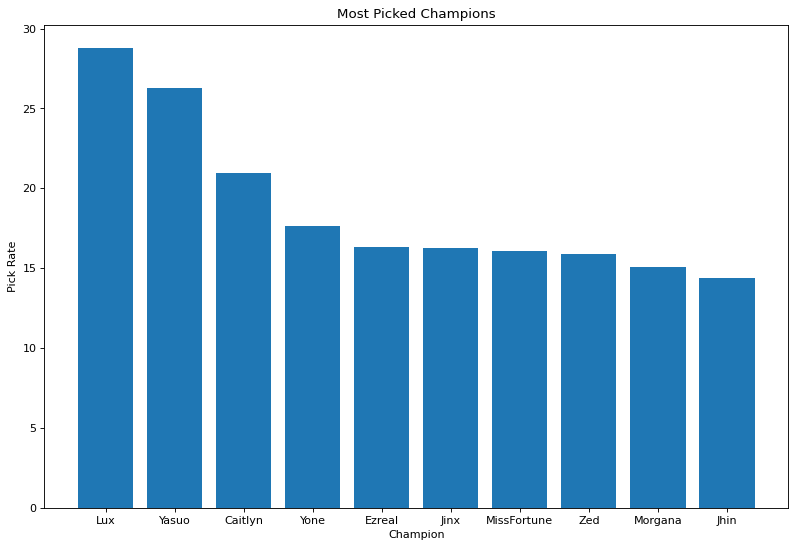

In [64]:
figure(figsize=(12, 8), dpi=80)
plt.bar(*zip(*top_champions_pick_rate))
plt.title('Most Picked Champions')
plt.xlabel('Champion')
plt.ylabel('Pick Rate')
plt.show()

### Champions win rate

In [54]:
with open("champions_win_rate", "r") as file:
  champions_win_rate = file.read()
  champions_win_rate = ast.literal_eval(champions_win_rate)
print(champions_win_rate)

champions_win_rate = sorted(champions_win_rate, key=lambda tup: tup[1], reverse=True)
print(champions_win_rate)

[('Hecarim', 52.99), ('Darius', 48.65), ('Nunu', 49.47), ('Amumu', 54.08), ('Zac', 52.49), ('Nautilus', 51.04), ('TwistedFate', 50.59), ('Vex', 49.43), ('Gangplank', 48.12), ('Singed', 49.69), ('Zyra', 53.26), ('Trundle', 51.46), ('Shen', 52.3), ('Olaf', 36.89), ('Illaoi', 54.05), ('Veigar', 52.1), ('Swain', 51.85), ('Cassiopeia', 48.5), ('XinZhao', 57.48), ('TahmKench', 49.26), ('Varus', 50.33), ('Quinn', 50.63), ('Katarina', 49.34), ('Sona', 51.6), ('Graves', 48.75), ('Sion', 52.45), ('Warwick', 52.29), ('Orianna', 48.61), ('Camille', 48.29), ('Nocturne', 45.81), ('Aphelios', 50.97), ('Blitzcrank', 47.0), ('Anivia', 48.32), ('Ashe', 49.06), ('Udyr', 45.54), ('Nami', 54.63), ('Jayce', 47.03), ('Zoe', 44.03), ('Sett', 51.19), ('Braum', 48.95), ('Chogath', 52.44), ('Lux', 54.19), ('Jax', 51.87), ('Skarner', 47.2), ('Janna', 48.95), ('Syndra', 52.57), ('Yorick', 55.01), ('Kindred', 46.37), ('Taric', 44.99), ('Qiyana', 43.98), ('Sylas', 45.84), ('Karthus', 50.93), ('Riven', 46.62), ('Pyke

In [58]:
top_champions_win_rate = champions_win_rate[0:10]

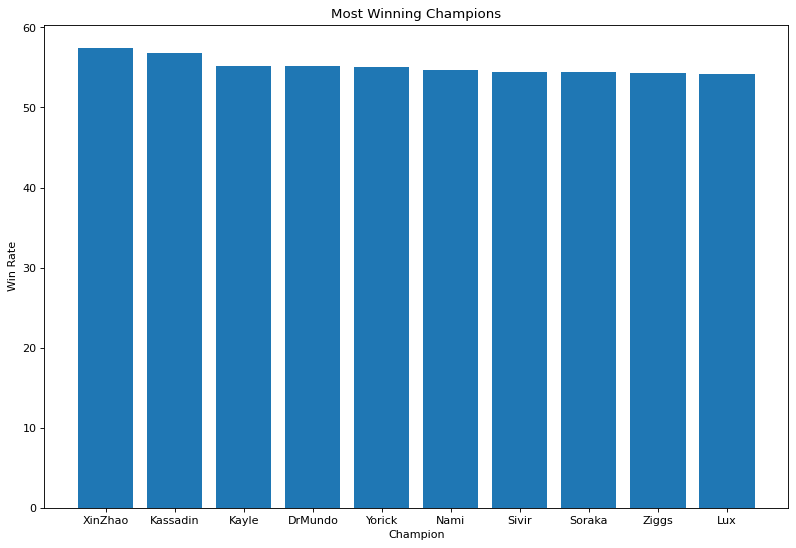

In [65]:
figure(figsize=(12, 8), dpi=80)
plt.bar(*zip(*top_champions_win_rate))
plt.title('Most Winning Champions')
plt.xlabel('Champion')
plt.ylabel('Win Rate')
plt.show()

### Champions ban rate

In [92]:
with open("champions_ban_rate_names.txt", "r") as file:
  champions_ban_rate = file.read()
  champions_ban_rate = ast.literal_eval(champions_ban_rate)

j = 0
new_champions_ban_rate = []
for i in range(len(champions_ban_rate)-2):
  try:
    new_champions_ban_rate.append((champions_ban_rate[j], champions_ban_rate[j+1]))
    j+=2
  except:
    break

champions_ban_rate = [(l[0],l[1]) for l in new_champions_ban_rate]
print(champions_ban_rate)

champions_ban_rate = sorted(champions_ban_rate, key=lambda tup: tup[1], reverse=True)
print(champions_ban_rate)

['Renekton', 1.5181624117044725, 'Lulu', 7.497526857460213, 'Annie', 0.3353928391676357, 'Jarvan IV', 0.21694232805151079, 'Aphelios', 0.8664676582377341, 'Yuumi', 5.202710911331332, 'Viego', 2.7412832572588903, 'Elise', 0.29894652805498184, 'Olaf', 0.5184921640431108, 'Draven', 2.833700689008834, 'Senna', 1.3845259376247419, 'Galio', 0.10760339471354935, 'Orianna', 0.12495878095767021, 'Lucian', 2.8619031916555304, 'Wukong', 0.17919436297054792, 'Hecarim', 0.45124004234714243, 'Rell', 0.25165310053975254, 'Twisted Fate', 0.050764504764053524, 'Sett', 7.012443811937034, "Kha'Zix", 1.569360801124629, 'Brand', 2.9833908953643764, 'Xin Zhao', 0.803988267758899, 'Zed', 20.918447040038878, 'Darius', 10.983356184591887, 'Urgot', 0.8178725767541957, 'Lee Sin', 5.180148909213974, 'Thresh', 1.4956004095871154, 'Lillia', 0.5158888561064926, 'LeBlanc', 2.48138634825318, 'Kled', 0.4304135788541974, 'Vladimir', 0.9862198233221681, 'Vayne', 5.531595480657422, 'Fiddlesticks', 0.20739686561724432, 'Ka

In [93]:
top_champions_ban_rate = champions_ban_rate[0:10]

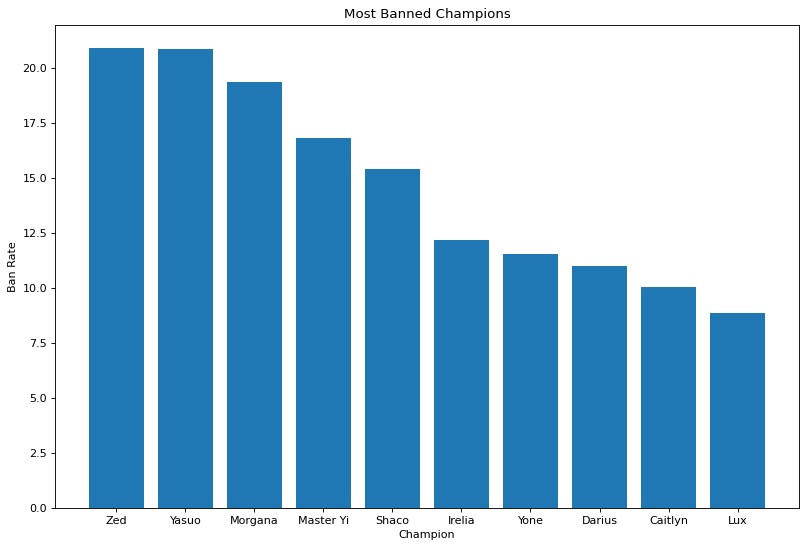

In [94]:
figure(figsize=(12, 8), dpi=80)
plt.bar(*zip(*top_champions_ban_rate))
plt.title('Most Banned Champions')
plt.xlabel('Champion')
plt.ylabel('Ban Rate')
plt.show()

## Requirement II:

### Champions synergies

In [101]:
with open("champions_synergies.txt", "r") as file:
  champions_synergies = file.read()
  champions_synergies = ast.literal_eval(champions_synergies)
print(champions_synergies)

champions_synergies = sorted(champions_synergies, key=lambda tup: tup[1], reverse=True)
print(champions_synergies)

[(('Shyvana', 'Syndra'), 75.51), (('Khazix', 'Lucian'), 46.3), (('MissFortune', 'Zyra'), 50.38), (('Galio', 'Graves'), 53.76), (('MissFortune', 'Nidalee'), 50.29), (('Ahri', 'Gragas'), 32.06), (('Lulu', 'Veigar'), 38.01), (('Morgana', 'Poppy'), 46.59), (('DrMundo', 'Malphite'), 55.36), (('Diana', 'Lillia'), 48.28), (('Ekko', 'Teemo'), 40.18), (('Brand', 'Xayah'), 30.48), (('Ezreal', 'Kindred'), 46.34), (('Jax', 'KogMaw'), 59.7), (('Jax', 'Seraphine'), 47.81), (('Gwen', 'Qiyana'), 45.74), (('Ezreal', 'Kayle'), 52.76), (('Ezreal', 'Leona'), 47.61), (('Shaco', 'Velkoz'), 25.29), (('Malzahar', 'Trundle'), 64.29), (('Darius', 'Katarina'), 51.04), (('Kaisa', 'Shaco'), 40.31), (('Evelynn', 'Jayce'), 39.79), (('Samira', 'Viktor'), 51.67), (('Singed', 'Zed'), 41.15), (('Shyvana', 'Zac'), 65.0), (('Leblanc', 'Nasus'), 47.3), (('Malzahar', 'Thresh'), 49.43), (('Galio', 'Sylas'), 60.0), (('Sylas', 'Urgot'), 43.75), (('LeeSin', 'Vex'), 56.68), (('Lux', 'Viktor'), 54.46), (('FiddleSticks', 'Malphite

In [165]:
len(champions_synergies)

12174

In [166]:
12174/50

243.48

In [170]:
top_champions_syn = champions_synergies[0::300]

In [171]:
top_champions_syn

[(('Elise', 'Khazix'), 100.0),
 (('JarvanIV', 'Kindred'), 79.17),
 (('Ivern', 'Shyvana'), 73.33),
 (('DrMundo', 'Evelynn'), 69.57),
 (('Nunu', 'Ornn'), 66.67),
 (('Braum', 'Katarina'), 64.78),
 (('Teemo', 'Udyr'), 63.01),
 (('Cassiopeia', 'Soraka'), 61.54),
 (('Amumu', 'Heimerdinger'), 60.14),
 (('Karthus', 'Zed'), 59.0),
 (('Kaisa', 'Talon'), 57.89),
 (('Braum', 'Irelia'), 56.93),
 (('Draven', 'Swain'), 55.93),
 (('Jayce', 'Sejuani'), 55.1),
 (('Udyr', 'Varus'), 54.29),
 (('Lulu', 'Varus'), 53.4),
 (('Ekko', 'Twitch'), 52.6),
 (('Kayle', 'Yuumi'), 51.83),
 (('Jayce', 'TwistedFate'), 51.04),
 (('Shaco', 'Swain'), 50.3),
 (('Aphelios', 'Yone'), 49.79),
 (('Garen', 'Rammus'), 48.89),
 (('Ezreal', 'MissFortune'), 48.05),
 (('Ezreal', 'Xayah'), 47.24),
 (('Cassiopeia', 'Morgana'), 46.39),
 (('Morgana', 'Xerath'), 45.59),
 (('MissFortune', 'Qiyana'), 44.77),
 (('Gragas', 'Senna'), 43.87),
 (('Draven', 'Rengar'), 42.86),
 (('Qiyana', 'Sett'), 41.86),
 (('Evelynn', 'Lucian'), 40.77),
 (('Jhin

In [172]:
figure(figsize=(12, 8), dpi=80)

x_val = [x[0] for x in top_champions_syn]
y_val = [x[1] for x in top_champions_syn]

print(x_val)
names = [item for t in x_val for item in t]
names = list(set(names))
print(len(names))

df = pd.DataFrame(index =names , data = np.zeros((len(names),len(names))), columns= names )

for i in range(len(top_champions_syn)):
  name1 = top_champions_syn[i][0][0]
  name2 = top_champions_syn[i][0][1]
  value = top_champions_syn[i][1]
  
  df[name1].loc[name2] = value


[('Elise', 'Khazix'), ('JarvanIV', 'Kindred'), ('Ivern', 'Shyvana'), ('DrMundo', 'Evelynn'), ('Nunu', 'Ornn'), ('Braum', 'Katarina'), ('Teemo', 'Udyr'), ('Cassiopeia', 'Soraka'), ('Amumu', 'Heimerdinger'), ('Karthus', 'Zed'), ('Kaisa', 'Talon'), ('Braum', 'Irelia'), ('Draven', 'Swain'), ('Jayce', 'Sejuani'), ('Udyr', 'Varus'), ('Lulu', 'Varus'), ('Ekko', 'Twitch'), ('Kayle', 'Yuumi'), ('Jayce', 'TwistedFate'), ('Shaco', 'Swain'), ('Aphelios', 'Yone'), ('Garen', 'Rammus'), ('Ezreal', 'MissFortune'), ('Ezreal', 'Xayah'), ('Cassiopeia', 'Morgana'), ('Morgana', 'Xerath'), ('MissFortune', 'Qiyana'), ('Gragas', 'Senna'), ('Draven', 'Rengar'), ('Qiyana', 'Sett'), ('Evelynn', 'Lucian'), ('Jhin', 'Twitch'), ('Fiora', 'Shyvana'), ('Blitzcrank', 'Leblanc'), ('Diana', 'Vladimir'), ('Azir', 'Warwick'), ('Khazix', 'Ornn'), ('Alistar', 'Pantheon'), ('Kled', 'Zoe'), ('Ivern', 'Rengar'), ('Gwen', 'Sejuani')]
63


<Figure size 960x640 with 0 Axes>

In [173]:
df.head()

,Lucian,Diana,Kindred,Sejuani,Azir,Leblanc,Alistar,Zed,Gwen,Jhin,Garen,Twitch,Draven,Yuumi,Morgana,JarvanIV,Xayah,Warwick,Rammus,Qiyana,Pantheon,Kled,Udyr,Kaisa,Rengar,Kayle,Xerath,Khazix,Soraka,Aphelios,Yone,Evelynn,Shaco,Sett,Nunu,Varus,Gragas,Heimerdinger,Karthus,Swain,Ornn,TwistedFate,Talon,Amumu,Ezreal,Senna,Blitzcrank,Jayce,Braum,MissFortune,Irelia,Katarina,DrMundo,Teemo,Ivern,Ekko,Zoe,Shyvana,Fiora,Lulu,Cassiopeia,Elise,Vladimir
Lucian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Diana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kindred,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,79.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sejuani,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.79,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Azir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


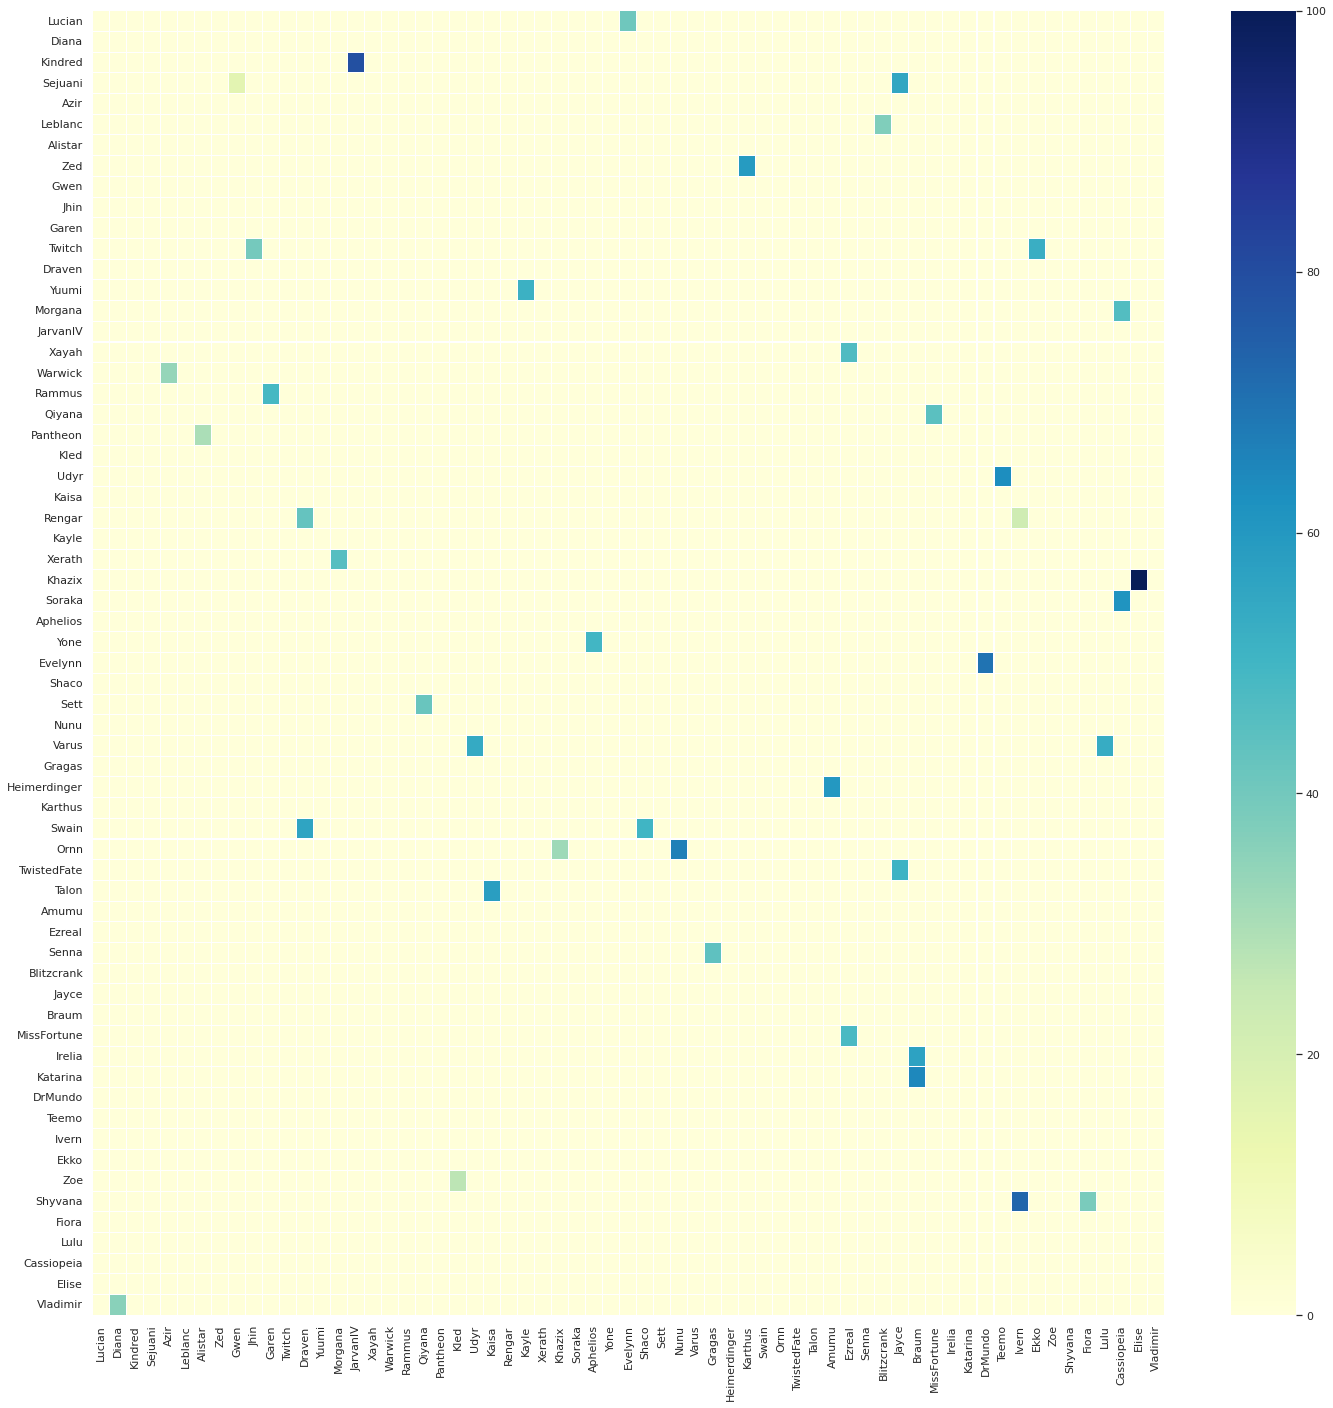

In [174]:
sns.set(rc={'figure.figsize':(24,24)})
sns.heatmap(df, cmap="YlGnBu",linewidths=0.01);

In [17]:
duos_win = duos_win_count.collect()

In [18]:
duos_win

[(('Shyvana', 'Syndra'), 37),
 (('Khazix', 'Lucian'), 144),
 (('MissFortune', 'Zyra'), 268),
 (('Galio', 'Graves'), 50),
 (('MissFortune', 'Nidalee'), 171),
 (('Ahri', 'Gragas'), 92),
 (('Lulu', 'Veigar'), 141),
 (('Morgana', 'Poppy'), 171),
 (('DrMundo', 'Malphite'), 93),
 (('Diana', 'Lillia'), 28),
 (('Ekko', 'Teemo'), 229),
 (('Brand', 'Xayah'), 121),
 (('Ezreal', 'Kindred'), 95),
 (('Jax', 'KogMaw'), 120),
 (('Jax', 'Seraphine'), 218),
 (('Gwen', 'Qiyana'), 59),
 (('Ezreal', 'Kayle'), 268),
 (('Ezreal', 'Leona'), 229),
 (('Shaco', 'Velkoz'), 86),
 (('Malzahar', 'Trundle'), 63),
 (('Darius', 'Katarina'), 171),
 (('Kaisa', 'Shaco'), 237),
 (('Evelynn', 'Jayce'), 115),
 (('Samira', 'Viktor'), 93),
 (('Singed', 'Zed'), 172),
 (('Shyvana', 'Zac'), 13),
 (('Leblanc', 'Nasus'), 105),
 (('Malzahar', 'Thresh'), 86),
 (('Galio', 'Sylas'), 36),
 (('Sylas', 'Urgot'), 63),
 (('LeeSin', 'Vex'), 212),
 (('Lux', 'Viktor'), 391),
 (('FiddleSticks', 'Malphite'), 60),
 (('Blitzcrank', 'Yone'), 465),


In [19]:
duos_win = sorted(duos_win, key=lambda tup: tup[1], reverse=True)
duos_win = duos_win[0:10]

In [20]:
figure(figsize=(12, 8), dpi=80)

x_val = [x[0] for x in duos_win]
y_val = [x[1] for x in duos_win]

print(x_val)
names = [item for t in x_val for item in t]
names = list(set(names))
print(len(names))

df = pd.DataFrame(index =names , data = np.zeros((len(names),len(names))), columns= names )

for i in range(len(duos_win)):
  name1 = duos_win[i][0][0]
  name2 = duos_win[i][0][1]
  value = duos_win[i][1]
  
  df[name1].loc[name2] = value


[('Lux', 'Yasuo'), ('Caitlyn', 'Lux'), ('Lux', 'MissFortune'), ('Lux', 'MasterYi'), ('Caitlyn', 'Yasuo'), ('Lux', 'Yone'), ('Jinx', 'Lux'), ('Jhin', 'Lux'), ('Lux', 'Zed'), ('Ezreal', 'Lux')]
10


<Figure size 960x640 with 0 Axes>

In [21]:
df.head()

,Yone,Jinx,Jhin,MasterYi,Ezreal,Lux,Zed,MissFortune,Caitlyn,Yasuo
Yone,0.0,0.0,0.0,0.0,0.0,1445.0,0.0,0.0,0.0,0.0
Jinx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jhin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MasterYi,0.0,0.0,0.0,0.0,0.0,1502.0,0.0,0.0,0.0,0.0
Ezreal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


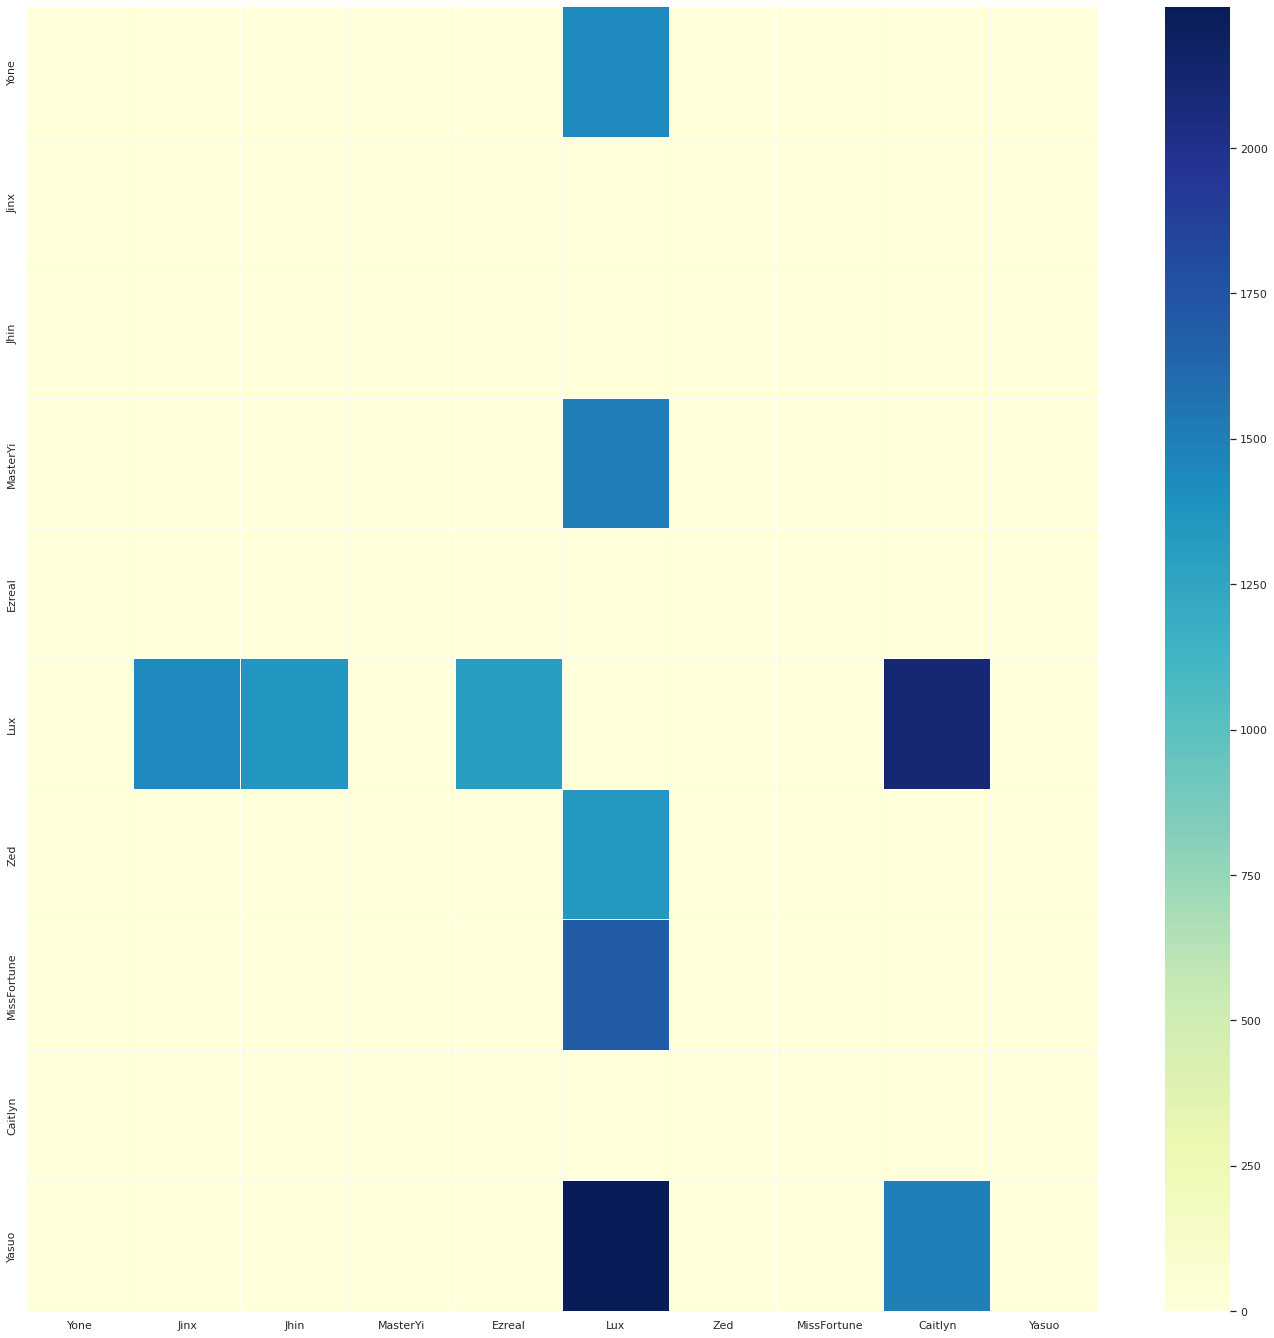

In [22]:
sns.set(rc={'figure.figsize':(24,24)})
sns.heatmap(df, cmap="YlGnBu",linewidths=0.01);

## Requirement III:

### Item pick rate

In [49]:
with open("items_pick_rate_names", "r") as file:
  items_pick_rate = file.read()
  items_pick_rate = ast.literal_eval(items_pick_rate)

print(items_pick_rate)

j = 0
new_items_pick_rate = []
for i in range(len(items_pick_rate)-2):
  try:
    rate = items_pick_rate[j+1][0:-1]
    new_items_pick_rate.append((items_pick_rate[j], round(float(rate),2)))
    j+=2
  except:
    break

#new_items_pick_rate = [(l[0],l[1]) for l in items_pick_rate]
print(new_items_pick_rate)

items_pick_rate = sorted(new_items_pick_rate, key=lambda tup: tup[1], reverse=True)
print(items_pick_rate)

['Locket of the Iron Solari', '1.7300716777451883%', 'Ravenous Hydra', '1.6380881306513477%', 'Noonquiver', '0.6303476283864697%', 'Refillable Potion', '8.472639233586143%', "Seeker's Armguard", '1.4516912823894896%', "Caulfield's Warhammer", '3.548135163748069%', 'Galeforce', '4.610545132681928%', 'Thornmail', '7.2361547406237525%', 'Kraken Slayer', '7.995019004147937%', 'Serrated Dirk', '3.647668303858102%', 'Bramble Vest', '3.021138860445339%', 'Bandleglass Mirror', '0.40498793800656036%', 'Immortal Shieldbow', '10.808587445113591%', 'Corrupting Potion', '2.641489786355195%', 'Void Staff', '5.915670178239817%', 'Imperial Mandate', '0.8587445113591003%', 'Vigilant Wardstone', '0.1345042433919367%', 'Tiamat', '1.0769017164476995%', 'Gargoyle Stoneplate', '0.9554140127388535%', 'Silvermere Dawn', '0.12105381905274303%', "Kalista's Black Spear", '0.0028636387302799424%', "Sorcerer's Shoes", '23.923532168208403%', 'Crown of the Shattered Queen', '1.9457991287596106%', 'Staff of Flowing W

In [53]:
items_pick_rate = items_pick_rate[0:5]

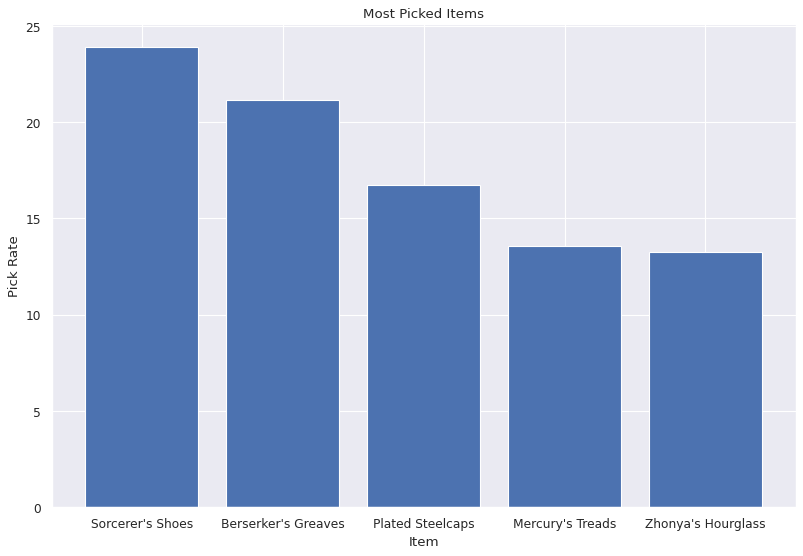

In [56]:
figure(figsize=(12, 8), dpi=80)
plt.bar(*zip(*items_pick_rate))
plt.title('Most Picked Items')
plt.xlabel('Item')
plt.ylabel('Pick Rate')
plt.show()

### Item win rate

In [66]:
with open("items_win_rate_names", "r") as file:
  items_win_rate = file.read()
  items_win_rate = ast.literal_eval(items_win_rate)

print(items_win_rate)

j = 0
new_items_win_rate = []
for i in range(len(items_win_rate)-2):
  try:
    rate = items_win_rate[j+1]
    new_items_win_rate.append((items_win_rate[j], round(float(rate),2)))
    j+=2
  except:
    break

#new_items_pick_rate = [(l[0],l[1]) for l in items_pick_rate]
print(new_items_win_rate)

items_win_rate = sorted(new_items_win_rate, key=lambda tup: tup[1], reverse=True)
print(items_win_rate)

['Locket of the Iron Solari', 50.22, 'Ravenous Hydra', 53.62, 'Noonquiver', 28.15, 'Refillable Potion', 48.13, "Seeker's Armguard", 44.56, "Caulfield's Warhammer", 45.56, 'Galeforce', 50.32, 'Thornmail', 53.41, 'Kraken Slayer', 51.39, 'Serrated Dirk', 47.5, 'Bramble Vest', 47.0, 'Bandleglass Mirror', 40.24, 'Immortal Shieldbow', 52.77, 'Corrupting Potion', 46.73, 'Void Staff', 51.07, 'Imperial Mandate', 53.29, 'Vigilant Wardstone', 60.13, 'Tiamat', 54.38, 'Gargoyle Stoneplate', 52.99, 'Silvermere Dawn', 54.41, "Kalista's Black Spear", 39.39, "Sorcerer's Shoes", 51.18, 'Crown of the Shattered Queen', 51.95, 'Staff of Flowing Water', 56.55, 'Trinity Force', 49.87, "Kalista's Black Spear", 100.0, 'Shadowflame', 52.43, 'Moonstone Renewer', 52.65, 'Navori Quickblades', 51.38, 'The Collector', 52.99, 'Rageknife', 51.8, 'Mercurial Scimitar', 51.39, 'Amplifying Tome', 46.8, "Warden's Mail", 49.74, 'Glacial Buckler', 48.98, 'Quicksilver Sash', 56.34, 'Vampiric Scepter', 46.04, "Warmog's Armor",

In [69]:
items_win_rate = items_win_rate[0:5]

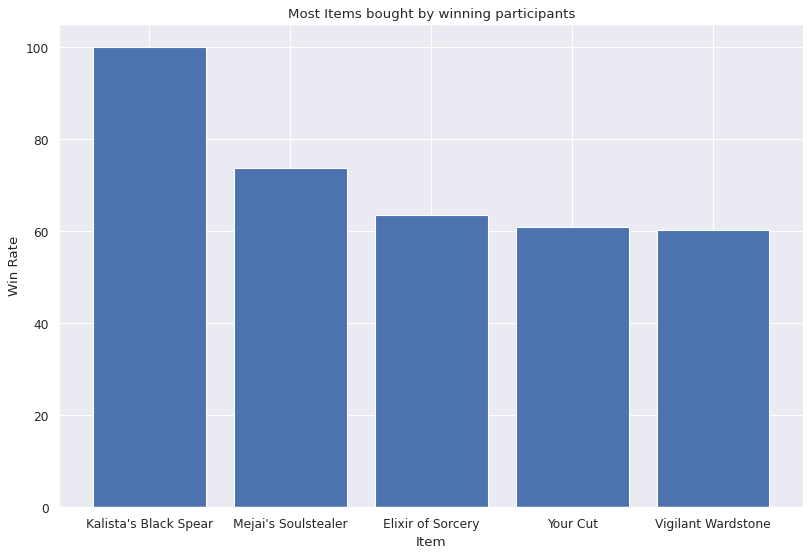

In [70]:
figure(figsize=(12, 8), dpi=80)
plt.bar(*zip(*items_win_rate))
plt.title('Most Items bought by winning participants')
plt.xlabel('Item')
plt.ylabel('Win Rate')
plt.show()

## Requirement IV:

### Item with champion synergies

In [14]:
with open("champions_item_synergies_names", "r") as file:
  champions_item_synergies = file.read()
  champions_item_synergies = ast.literal_eval(champions_item_synergies)
print(champions_item_synergies)

# j = 0
# new_champions_item_synergies = []
# for i in range(len(champions_item_synergies)-2):
#   try:
#     new_champions_item_synergies.append((champions_item_synergies[j], champions_item_synergies[j+1]))
#     j+=2
#   except:
#     break

champions_item_synergies = sorted(new_champions_item_synergies, key=lambda tup: tup[1], reverse=True)
print(champions_item_synergies)

[('Rengar', 'Horizon Focus'), 100.0, ('Lillia', 'Slightly Magical Footwear'), 100.0, ('Jhin', "Knight's Vow"), 100.0, ('Annie', "Mikael's Blessing"), 100.0, ('Zilean', "Serpent's Fang"), 100.0, ('Lillia', 'Guardian Angel'), 100.0, ('Jayce', 'Glacial Buckler'), 100.0, ('Singed', 'Hailblade'), 100.0, ('KogMaw', 'Duskblade of Draktharr'), 100.0, ('Illaoi', 'Blade of The Ruined King'), 100.0, ('Zed', "Spectre's Cowl"), 100.0, ('Mordekaiser', "Guardian's Orb"), 100.0, ('Heimerdinger', 'Kraken Slayer'), 100.0, ('Kayle', "Banshee's Veil"), 100.0, ('Jax', 'Stormrazor'), 100.0, ('Ryze', 'Winged Moonplate'), 100.0, ('Varus', "Mejai's Soulstealer"), 100.0, ('Nidalee', 'Muramana'), 100.0, ('Qiyana', 'Stridebreaker'), 100.0, ('Volibear', 'Broken Stopwatch'), 100.0, ('Taliyah', 'Null-Magic Mantle'), 100.0, ('Rumble', 'Frostfang'), 100.0, ('Tristana', "Guardian's Blade"), 100.0, ('Yasuo', "Banshee's Veil"), 100.0, ('Malzahar', 'Bulwark of the Mountain'), 100.0, ('Trundle', 'Rapid Firecannon'), 100.0,

In [25]:
# use: 
duos_win_items = duos_win_count_items.collect()

In [26]:
duos_win_items

[(('MasterYi', 1037), 507),
 (('Rakan', 3860), 1062),
 (('Velkoz', 4630), 216),
 (('Gragas', 3041), 24),
 (('MissFortune', 3094), 493),
 (('Lux', 3157), 6253),
 (('Volibear', 6664), 199),
 (('Gangplank', 3031), 1170),
 (('Soraka', 3158), 3339),
 (('Kayn', 3158), 2303),
 (('Kaisa', 6672), 2529),
 (('Yorick', 1054), 209),
 (('Velkoz', 0), 2165),
 (('Morgana', 1026), 1202),
 (('Seraphine', 6653), 1242),
 (('DrMundo', 1001), 13),
 (('Warwick', 3047), 3406),
 (('Pantheon', 3047), 1161),
 (('Yasuo', 3026), 1826),
 (('Nidalee', 4636), 450),
 (('Sona', 3158), 1895),
 (('Aatrox', 3111), 781),
 (('Amumu', 3068), 1931),
 (('Zilean', 6655), 1005),
 (('Gnar', 3075), 611),
 (('Xerath', 2003), 125),
 (('Orianna', 3135), 453),
 (('Aatrox', 3077), 123),
 (('LeeSin', 3026), 708),
 (('Samira', 3111), 635),
 (('Singed', 3111), 939),
 (('Tristana', 1053), 459),
 (('Pyke', 2010), 1),
 (('Hecarim', 3158), 403),
 (('Jax', 1037), 462),
 (('Senna', 6696), 87),
 (('Corki', 3078), 24),
 (('MissFortune', 2010), 66

In [27]:
duos_win_items = sorted(duos_win_items, key=lambda tup: tup[1], reverse=True)
duos_win_items = duos_win_items[0:10]

In [72]:
duos_win_items

[(('Lux', 6655), 15070),
 (('Lux', 3020), 15020),
 (('Yasuo', 6673), 14355),
 (('Yasuo', 3006), 13617),
 (('Lux', 0), 11052),
 (('Caitlyn', 3006), 10957),
 (('Yone', 6673), 9916),
 (('Yasuo', 3031), 9839),
 (('Yone', 3006), 9054),
 (('Yasuo', 0), 9052)]

[('Rengar', 'Horizon Focus'), ('Lillia', 'Slightly Magical Footwear'), ('Jhin', "Knight's Vow"), ('Annie', "Mikael's Blessing"), ('Zilean', "Serpent's Fang"), ('Lillia', 'Guardian Angel'), ('Jayce', 'Glacial Buckler'), ('Singed', 'Hailblade'), ('KogMaw', 'Duskblade of Draktharr'), ('Illaoi', 'Blade of The Ruined King'), ('Zed', "Spectre's Cowl"), ('Mordekaiser', "Guardian's Orb"), ('Heimerdinger', 'Kraken Slayer'), ('Kayle', "Banshee's Veil"), ('Jax', 'Stormrazor'), ('Ryze', 'Winged Moonplate'), ('Varus', "Mejai's Soulstealer"), ('Nidalee', 'Muramana'), ('Qiyana', 'Stridebreaker'), ('Volibear', 'Broken Stopwatch'), ('Taliyah', 'Null-Magic Mantle'), ('Rumble', 'Frostfang'), ('Tristana', "Guardian's Blade"), ('Yasuo', "Banshee's Veil"), ('Malzahar', 'Bulwark of the Mountain'), ('Trundle', 'Rapid Firecannon'), ('Gnar', "Zhonya's Hourglass"), ('Malphite', 'Moonstone Renewer'), ('Olaf', 'Zeal'), ('Fizz', "Winter's Approach"), ('Ivern', 'Sapphire Crystal'), ('Anivia', 'Frozen Heart'), ('Tryn

<BarContainer object of 47 artists>

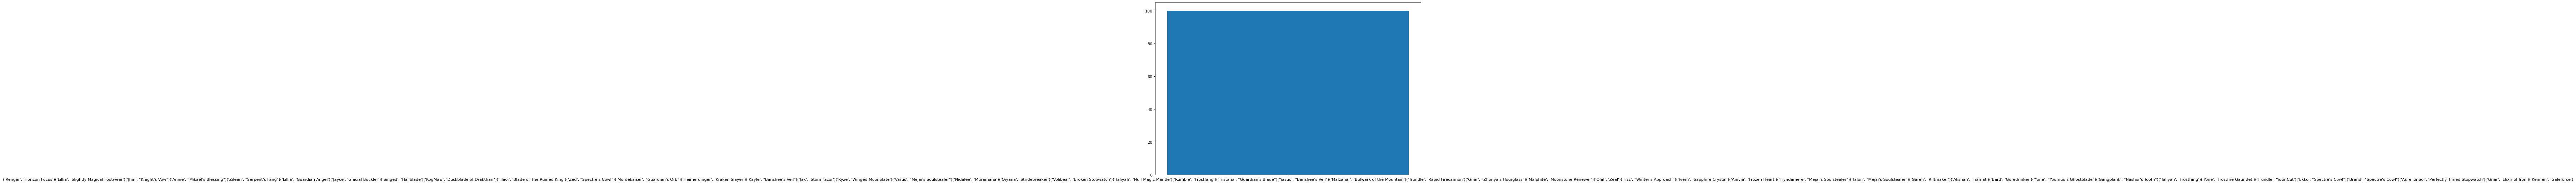

In [28]:
figure(figsize=(12, 8), dpi=80)

x_val = [x[0] for x in champions_item_synergies]
y_val = [x[1] for x in champions_item_synergies]

print(x_val)
print(''.join(map(str,x_val)))
print(y_val)

plt.bar( ''.join(map(str,x_val)), y_val)

# names = [item for t in x_val for item in t]
# names = list(set(names))
# print(len(names))

# df_items = pd.DataFrame(index =names , data = np.zeros((len(names),len(names))), columns= names )

# for i in range(len(duos_win)):
#   name1 = duos_win_items[i][0][0]
#   name2 = duos_win_items[i][0][1]
#   value = duos_win_items[i][1]
  
#   df_items[name1].loc[name2] = value


In [30]:
df_items.head()

,0,Yone,6655,3020,6673,Lux,3031,Caitlyn,3006,Yasuo
0,0.0,0.0,0.0,0.0,0.0,11052.0,0.0,0.0,0.0,9052.0
Yone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6655,0.0,0.0,0.0,0.0,0.0,15070.0,0.0,0.0,0.0,0.0
3020,0.0,0.0,0.0,0.0,0.0,15020.0,0.0,0.0,0.0,0.0
6673,0.0,9916.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14355.0


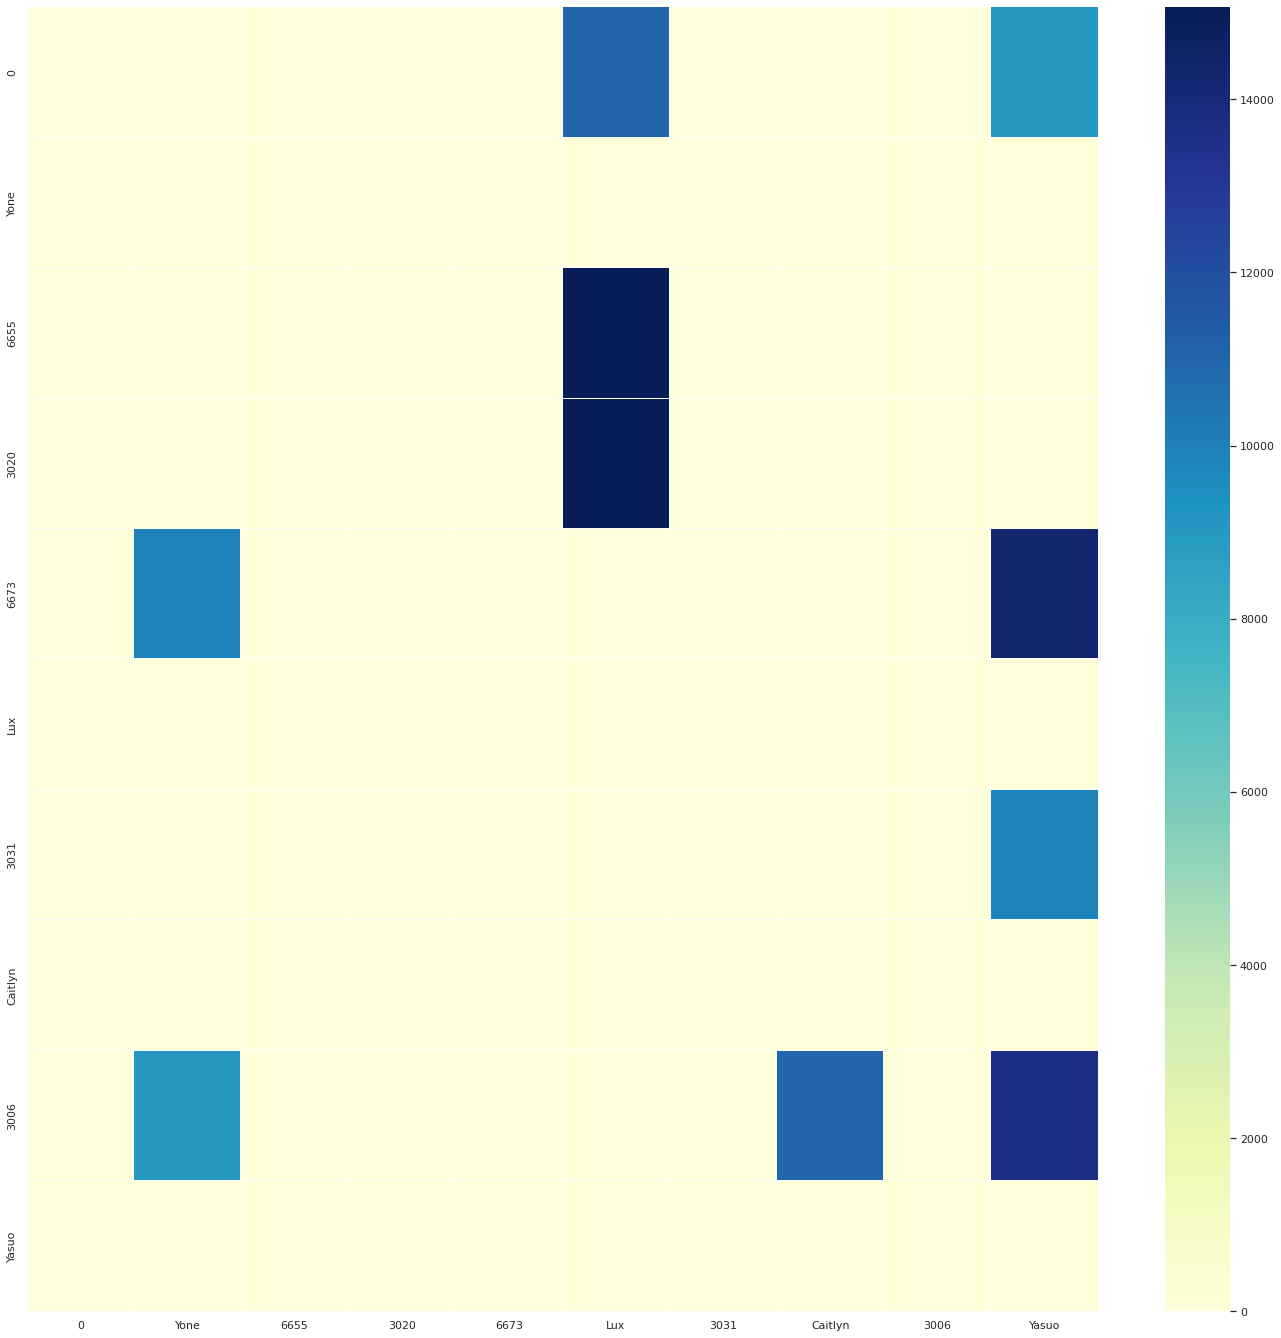

In [31]:
sns.set(rc={'figure.figsize':(24,24)})
sns.heatmap(df_items, cmap="YlGnBu",linewidths=0.01);

## Requirement V:

### Item suggestions

In [71]:
df_items.describe()

,0,Yone,6655,3020,6673,Lux,3031,Caitlyn,3006,Yasuo
count,10.0,10.000000,10.0,10.0,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,1897.000000,0.0,0.0,0.0,4114.200000,0.0,1095.700000,0.0,4686.300000
std,0.0,4004.384847,0.0,0.0,0.0,6713.051861,0.0,3464.907632,0.0,6241.610032
min,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
25%,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
50%,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
75%,0.0,0.000000,0.0,0.0,0.0,8289.000000,0.0,0.000000,0.0,9642.250000
max,0.0,9916.000000,0.0,0.0,0.0,15070.000000,0.0,10957.000000,0.0,14355.000000


In [77]:
champions_items_synergies.max(key= lambda tup: tup[1])

(('Rengar', 4628), 100.0)

In [85]:
champions_items_synergies = champions_items_synergies.sortBy(lambda tup: tup[1], ascending=False)

In [90]:
champions_items_synergies.toDF().show(5)

+--------------+-----+
|            _1|   _2|
+--------------+-----+
|{Rengar, 4628}|100.0|
|{Lillia, 2422}|100.0|
|  {Jhin, 3109}|100.0|
| {Annie, 3222}|100.0|
|{Zilean, 6695}|100.0|
+--------------+-----+
only showing top 5 rows



In [94]:
new_ls

['Horizon Focus',
 100.0,
 'Slightly Magical Footwear',
 100.0,
 "Knight's Vow",
 100.0,
 "Mikael's Blessing",
 100.0,
 "Serpent's Fang",
 100.0,
 'Guardian Angel',
 100.0,
 'Glacial Buckler',
 100.0,
 'Hailblade',
 100.0,
 'Duskblade of Draktharr',
 100.0,
 'Blade of The Ruined King',
 100.0,
 "Spectre's Cowl",
 100.0,
 "Guardian's Orb",
 100.0,
 'Kraken Slayer',
 100.0,
 "Banshee's Veil",
 100.0,
 'Stormrazor',
 100.0,
 'Winged Moonplate',
 100.0,
 "Mejai's Soulstealer",
 100.0,
 'Muramana',
 100.0,
 'Stridebreaker',
 100.0,
 'Broken Stopwatch',
 100.0,
 'Null-Magic Mantle',
 100.0,
 'Frostfang',
 100.0,
 "Guardian's Blade",
 100.0,
 "Banshee's Veil",
 100.0,
 'Bulwark of the Mountain',
 100.0,
 'Rapid Firecannon',
 100.0,
 "Zhonya's Hourglass",
 100.0,
 'Moonstone Renewer',
 100.0,
 'Zeal',
 100.0,
 "Winter's Approach",
 100.0,
 'Sapphire Crystal',
 100.0,
 'Frozen Heart',
 100.0,
 "Mejai's Soulstealer",
 100.0,
 "Mejai's Soulstealer",
 100.0,
 'Riftmaker',
 100.0,
 'Tiamat',
 100.0

In [93]:
pd.DataFrame(new_ls)

,0
0,Horizon Focus
1,100
2,Slightly Magical Footwear
3,100
4,Knight's Vow
...,...
89,100
90,Elixir of Iron
91,100
92,Galeforce
